In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from ex4_utils import *
import sympy as sp

In [33]:
def NCV():
    T, q = sp.symbols("T, q")
    F = sp.Matrix([[0,0,1,0],
                [0,0,0,1],
                [0,0,0,0],
                [0,0,0,0]])

    AS = sp.exp(F*T)
    LS = sp.Matrix([[0,0],
                [0,0],
                [1,0],
                [0,1]])
    Q_iS = sp.integrate((AS*LS)*q*(AS*LS).T, (T, 0, T))

    CS = sp.Matrix([[1, 0, 0, 0],
                [0, 1, 0, 0]])

    r = sp.symbols("r")
    R_iS = sp.Matrix([[r, 0],
                    [0, r]])
    
    return T, q, r, AS, LS, Q_iS, CS, R_iS

def resample_particles(particles, weights):
    weights_norm = weights/np.sum(weights)
    weights_cumsumed = np.cumsum(weights_norm)
    rand_samples = np.random.rand(N, 1)
    sampled_idxs = np.digitize(rand_samples, weights_cumsumed)
    particles_new = particles[sampled_idxs.flatten(), :]
    return particles_new

def hellinger_distance(h1, h2):
    # Ensure L1-normalized histograms
    h1 = h1 / np.sum(h1)
    h2 = h2 / np.sum(h2)
    
    return np.sqrt(1 - np.sum(np.sqrt(h1 * h2)))

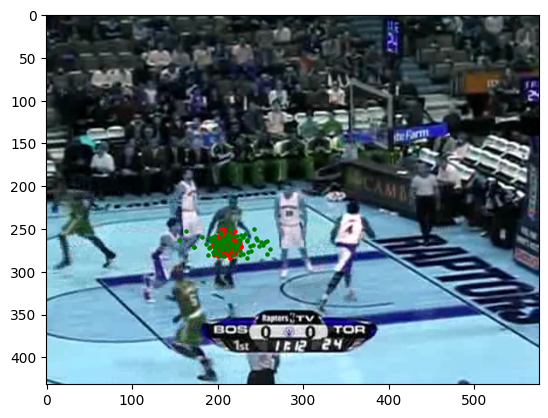

In [40]:
im = cv2.imread("vids/basketball/00000001.jpg")


region = [188.62,321.46,194.43,210.61,231.38,212.54,225.57,323.39]

if len(region) == 8:
    x_ = np.array(region[::2])
    y_ = np.array(region[1::2])
    region = [np.min(x_), np.min(y_), np.max(x_) - np.min(x_) + 1, np.max(y_) - np.min(y_) + 1]
        
    position = (region[0] + region[2] / 2, region[1] + region[3] / 2) # X x Y
    x = position[0]
    y = position[1]

    target_width = region[2] if region[2] %2 == 1 else region[2] + 1
    target_height = region[3] if region[3] %2 == 1 else region[3] + 1

    region_width = (math.floor((region[2] * 1) / 2) * 2) + 1
    region_height = (math.floor((region[3] * 1) / 2) * 2) + 1

T, q, r, AS, LS, Q_iS, CS, R_iS = NCV()

epanechnik_kernel = create_epanechnik_kernel(region_width, region_height, 1)
patch, mask = get_patch(im, (x, y), (region_width, region_width))
h_tar = extract_histogram(patch, 16)

T_val = 1  # time step
q_val = 150.0
Q_i = np.array(Q_iS.subs({T: T_val, q: q_val}).evalf(), dtype=np.float32)
N = 100

particles = sample_gauss([x, y, 0, 0], Q_i, N)
weights = np.ones(particles.shape[0])/particles.shape[0]

plt.imshow(im)
plt.scatter(particles[:, 0], particles[:, 1], c="r", s=5)

A = np.array(AS.subs({T: T_val}).evalf(), dtype=np.float32)

particles_new = resample_particles(particles, weights)
particles_new = (A @ particles_new.T).T
particles_new += np.random.multivariate_normal(np.zeros(4), Q_i, particles_new.shape[0])


plt.scatter(particles_new[:, 0], particles[:, 1], c="g", s=5)

In [ ]:
sigma = 0.5
def reweight_particles(particles, weights):
    for i, particle in enumerate(particles):
        xc, yc = particle[0], particle[1]
        particle_patch, mask = get_patch(im, (xc, yc), (region_width, region_width))
        h_new = extract_histogram(particle_patch, 16)

        dist = hellinger_distance(h_new, h_tar)
        weights[i] = np.exp(-dist**2 / (2 * sigma**2))